Using device: cuda
DeepConvNet_A3(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=21, stride=21, padding=0)
  )
  (fc): Linear(in_features=512, out_features=100, bias=True)
)
[Epoch 1/100] Train Loss: 3.3933 | Val Acc: 15.56%
[Epoch 2/100] Train 

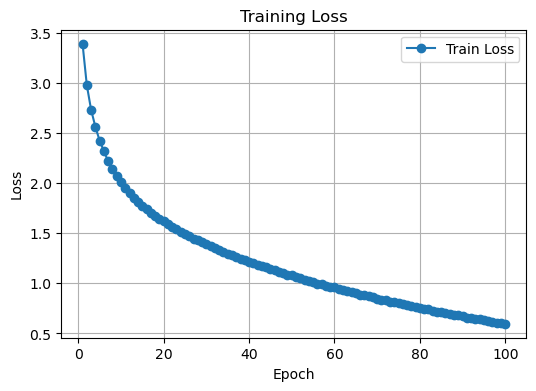

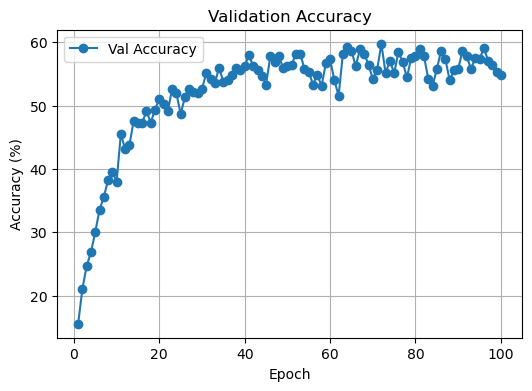


=== Final Results Table ===
| Method      |   #Param (M) |   MAdds (M) |   Top-1 (%) |
|:------------|-------------:|------------:|------------:|
| DeepConvNet |         0.72 |       406.2 |       55.56 |

Training history saved to 'metrics_history.csv' and final results saved to 'final_results.csv'.


In [1]:
# -------------------------------
# 1. 匯入必要套件
# -------------------------------
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 用於計算 FLOPs 與參數數量
from thop import profile
# 用於輸出 CSV 檔
import pandas as pd

# -------------------------------
# 2. 設定運算裝置 (GPU / CPU)
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 3. 定義讀取 txt 檔案的函式 (讀取圖片路徑與標籤)
# -------------------------------
def load_dataset(txt_file):
    """
    讀取 txt 檔，每行格式：'images/xxx/xxx.JPEG label'
    回傳 list of (image_path, label)
    """
    samples = []
    with open(txt_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                img_path, label = parts
                samples.append((img_path, int(label)))
    return samples

# -------------------------------
# 4. 自訂義 Dataset
# -------------------------------
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, label = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# 5. 設定影像前處理 (transforms)
# -------------------------------
transform_train = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transform_val_test = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------
# 6. 讀取 train.txt, val.txt, test.txt
# -------------------------------
train_samples = load_dataset('train.txt')
val_samples = load_dataset('val.txt')
test_samples = load_dataset('test.txt')

train_dataset = ImageDataset(train_samples, transform=transform_train)
val_dataset   = ImageDataset(val_samples,   transform=transform_val_test)
test_dataset  = ImageDataset(test_samples,  transform=transform_val_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

# -------------------------------
# 7. 定義修改後的卷積模型架構 (DeepConvNet_A3)
# -------------------------------
class DeepConvNet_A3(nn.Module):
    def __init__(self, num_classes=100):
        super(DeepConvNet_A3, self).__init__()
        # 第一層：3→64，84→42
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2)
        )
        # 第二層：64→128，42→21
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2)
        )
        # 第三層：128→512，21→1
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),

            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=21)  # 單純固定大小平均池化，不使用 AdaptiveAvgPool2d
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)           # 直接從 layer2 跳到 layer4
        x = x.view(x.size(0), -1)
        return self.fc(x)

# 建立並顯示模型
model = DeepConvNet_A3(num_classes=100).to(device)
print(model)

# -------------------------------
# 8. 定義損失函式與優化器
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# 9. 定義訓練與評估函式
# -------------------------------
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# -------------------------------
# 10. 主訓練迴圈
# -------------------------------
num_epochs = 100
loss_history, val_acc_history = [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_acc   = evaluate(model, val_loader, device)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

# -------------------------------
# 11. 測試集評估
# -------------------------------
test_acc = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# -------------------------------
# 12. 計算 FLOPs 與參數量
# -------------------------------
dummy_input = torch.randn(1, 3, 84, 84).to(device)
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
print(f"FLOPs: {flops:,}  Params: {params:,}")

# -------------------------------
# 13. 繪製學習曲線
# -------------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), [x*100 for x in val_acc_history],
         marker='o', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 14. 儲存最終結果與歷史紀錄
# -------------------------------
method_name = "DeepConvNet"
params_m = params / 1e6
madds = flops / 1e6
top1 = test_acc * 100

final_table = pd.DataFrame({
    "Method":         [method_name],
    "#Param (M)":     [f"{params_m:.2f}"],
    "MAdds (M)":      [f"{madds:.2f}"],
    "Top-1 (%)":      [f"{top1:.2f}"]
})
print("\n=== Final Results Table ===")
print(final_table.to_markdown(index=False))
final_table.to_csv("final_results.csv", index=False)

history_df = pd.DataFrame({
    "Epoch":        list(range(1, num_epochs+1)),
    "Train_Loss":   loss_history,
    "Val_Acc (%)":  [acc*100 for acc in val_acc_history]
})
history_df.to_csv("metrics_history.csv", index=False)
print("\nTraining history saved to 'metrics_history.csv' and final results saved to 'final_results.csv'.")
